# Centroid Measurement

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pickle
from astropy.io import fits
%matplotlib widget

The following script uploads the first science corrected frame

In [7]:
# Carico la lista dei file science
science_list = np.genfromtxt('./group10_WASP-135_20190803/science/science.list', dtype=str)
# Come per l'analisi fatta nella lezione precedente, carico solo i primi 30 frames.
science_test_list = science_list[:30]
# In questa variabile immagazzino il nome del primo corrected science frame.
science_frame_name = './group10_WASP-135_20190803/correct/' + science_test_list[0][:-5] + '_corr.p'
# Carico il file corrispondente a questo nome
science_corrected = pickle.load(open(science_frame_name, 'rb'))

### Identification of the target and reference stars

We now open and display a scientific frame and we identify the target star (the one with the transiting planet) and the reference stars (used to do differential photometry). By changing the $\texttt{vmin}$ and $\texttt{vmax}$ we can highlight fainter stars.

vmin:  1067.9   vmax: 110239.3


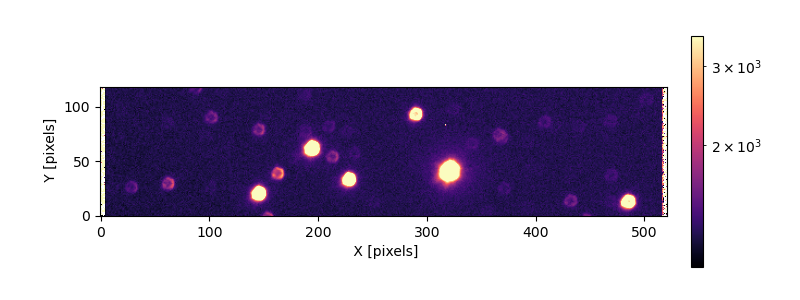

In [12]:
import matplotlib.colors as colors

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}   vmax: {1:.1f}'.format(vmin, vmax))

#Abbassiamo il vmax altrimenti non si vede molto
vmax=3500

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
plt.show()


From this frame we can get an approximate location of the star (in pixels). In this case we got:

- x_target = 228
- y_target = 33

- x_reference_01 = 146
- y_reference_01 = 21

- x_reference_02 = 194
- y_reference_02 = 62

- x_reference_03 = 290
- y_reference_03 = 93

We don't need to be extremely precise at this stage, we will refine the coordinates afterwards. In the next cell there is a function that creates a plot, we use a function since we will use this plot a lot and we need to be able to call it often.

In [ ]:
def make_circle_around_star(x_pos, y_pos, label='', color='w'):
    """
    This function creates a circle around the selected target in the science frame.

    Parameters:
    - x_pos: x coordinate of the target.
    - y_pos: y coordinate of the target.

    It does not return a variable but it produces a plot instead.
    """
    from matplotlib.patches import Circle

    n, radii = 50, [9, 15]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)
